# AutoEncoder

어제 다뤘던 이동통신 고객 이탈 데이터를 이용하여, AE 모델을 생성하고 예측해 봅시다.



## 1.환경준비

### 1) 라이브러리 로딩

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

2025-05-02 10:24:48.394006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 10:24:48.395693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 10:24:48.399342: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 10:24:48.406991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746149088.417894   14031 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746149088.42

### 2) 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [3]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)

    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [4]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

#### ④ DL 학습곡선 그리기


In [6]:
def plot_learning_curve(history) :
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

### 3) 데이터셋 불러오기

In [9]:
# secom
path = "secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)

target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [10]:
data.shape

(1567, 53)

In [11]:
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


In [12]:
y.value_counts()

label
0    1463
1     104
Name: count, dtype: int64

In [13]:
y.value_counts() / y.shape[0]

label
0    0.933631
1    0.066369
Name: count, dtype: float64

## 2.데이터 준비

* 분할

In [14]:
x.shape

(1567, 52)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state=2021)

In [16]:
x_train.shape, y_train.shape

((1253, 52), (1253,))

* 스케일링

In [17]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

* Normal 데이터만 뽑기

In [18]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train[y_train == 0]

In [19]:
x_train0.shape

(1166, 52)

## 3.모델링 : AE

### 1) 학습

* 모델 설계

In [20]:
input_dim = x_train0.shape[1]
input_dim

52

In [21]:
input_dim = x_train0.shape[1] #num of columns

clear_session()
autoencoder = Sequential([Dense(32, input_shape = (input_dim,), activation = 'relu'),
                          Dense(16, activation="relu"),
                          Dense(32, activation='relu'),
                          Dense(input_dim, activation='relu')])

autoencoder.summary()

/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-02 10:26:56.119207: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 52)             │         1,716 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,484 (17.52 KB)

 Trainable params: 4,484 (17.52 KB)

 Non-trainable params: 0 (0.00 B)

* compile + 학습

In [22]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=50, batch_size=64,
                          validation_split = .2).history

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1168 - val_loss: 0.0934
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0878 - val_loss: 0.0717
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0693 - val_loss: 0.0624
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0616 - val_loss: 0.0592
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0590 - val_loss: 0.0586
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0587 - val_loss: 0.0580
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0575 - val_loss: 0.0575
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - val_loss: 0.0417
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369 - val_loss: 0.0298
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.0290
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - val_loss: 0.0286
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - val_lo

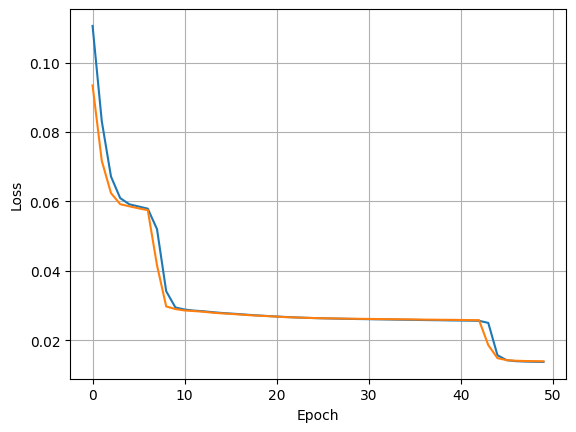

In [23]:
plot_learning_curve(history)

### 2) 예측 및 Reconstruction Error 계산

#### ① 예측

In [24]:
pred = autoencoder.predict(x_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


#### ② 재구성 오차 계산

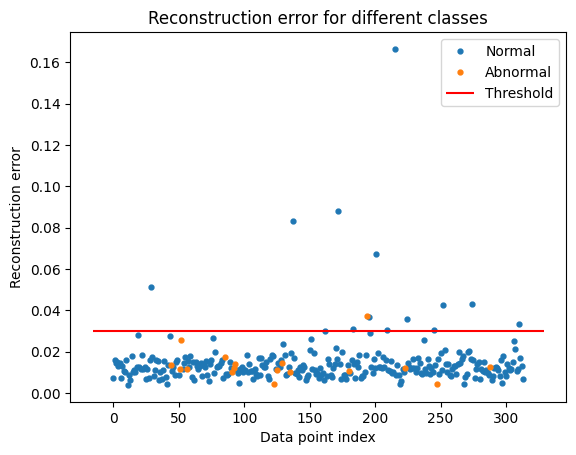

In [25]:
result = recon_err_plot(x_val, pred, y_val, .03)

In [26]:
result.head()

,index,Reconstruction_error,True_class
0,886,0.007131,0
1,759,0.016038,0
2,724,0.014321,0
3,737,0.015056,0
4,1352,0.013021,0


#### ③ Threshold 찾기 : precision_recall_f1_curve

/tmp/ipykernel_14031/3279574342.py:6: RuntimeWarning: divide by zero encountered in divide
  f1 = 2 / (1/precision + 1/recall)


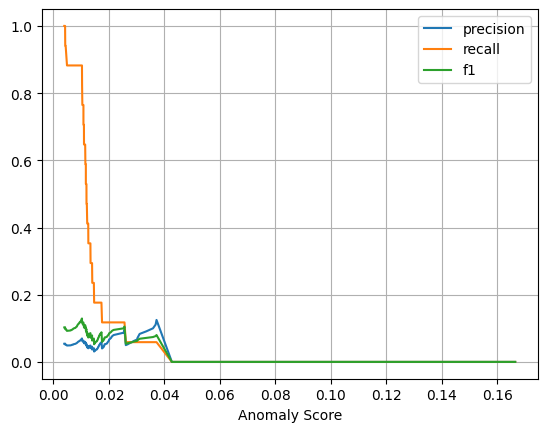

In [27]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

In [28]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.010269413796610675

#### ④ f1을 최대화 하는 threshold 값으로 잘라서 평가

In [29]:
classification_report2(result['True_class'], result['Reconstruction_error'], thres_f1_max)

< confusion matrix >

[[ 97 200]
 [  3  14]]


< classification_report >

              precision    recall  f1-score   support

           0       0.97      0.33      0.49       297
           1       0.07      0.82      0.12        17

    accuracy                           0.35       314
   macro avg       0.52      0.58      0.30       314
weighted avg       0.92      0.35      0.47       314



## 4.실습 : mobile 데이터

### 1) 데이터셋 불러오기

In [31]:
path = "mobile_class_imbalance.csv"
data = pd.read_csv(path)

target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [32]:
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,145297,71,37,969515,478,4,1,avg,very_little,no,0
1,0,115956,0,11,899704,710,0,5,unsat,very_high,actively_looking_into_it,0
2,0,40683,212,15,844664,188,24,5,very_unsat,very_little,no,0
3,1,33043,0,81,539732,162,1,1,unsat,very_little,never_thought,0
4,1,50743,0,22,430005,318,16,5,unsat,very_high,actively_looking_into_it,0


### 2) 데이터 준비

* 가변수화

In [33]:
cat = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']

for v in cat :
    dumm = pd.get_dummies(x[v], prefix=v, drop_first=True)
    x = pd.concat([x, dumm], axis=1)
    x.drop(v, axis=1, inplace = True)

* 데이터 분할

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 2000, random_state=2021)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state=2021)

* 스케일링

In [35]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

* Normal 데이터만 저장

In [36]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train[y_train == 0]

### 2) 모델링 : AE

#### ① 학습

In [40]:
input_dim = x_train0.shape[1]

In [41]:
clear_session()
autoencoder = Sequential([Dense(32, input_shape = (input_dim,), activation = 'relu'),
                          Dense(16, activation="relu"),
                          Dense(32, activation='relu'),
                          Dense(input_dim, activation='relu')])
autoencoder.summary()

/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,404 (9.39 KB)

 Trainable params: 2,404 (9.39 KB)

 Non-trainable params: 0 (0.00 B)

* compile + 학습

In [42]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=50, batch_size=64,
                          validation_split = .2).history

Epoch 1/50


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1647 - val_loss: 0.1140
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1023 - val_loss: 0.0672
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0617 - val_loss: 0.0532
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0494 - val_loss: 0.0405
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0383 - val_loss: 0.0371
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0358 - val_loss: 0.0362
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0349 - val_loss: 0.0357
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0346 - val_loss: 0.0353
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0342 - val_loss: 0.0350
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0344 - val_loss: 0.0347
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0342 - val_loss: 0.0345
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 - val_loss: 0.0342


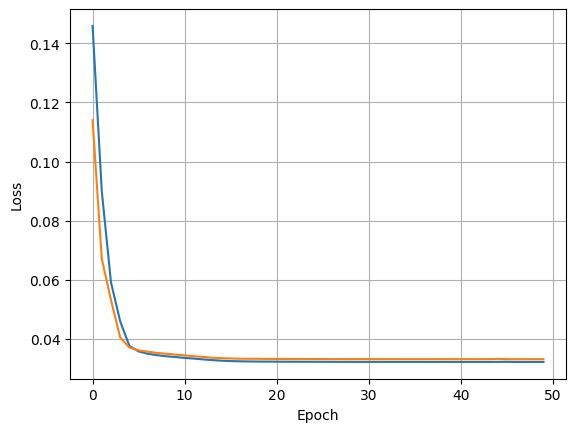

In [43]:
plot_learning_curve(history)

#### ② 예측 및 검증

* 예측

In [44]:
pred = autoencoder.predict(x_val)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


* 재구성 오차 그래프

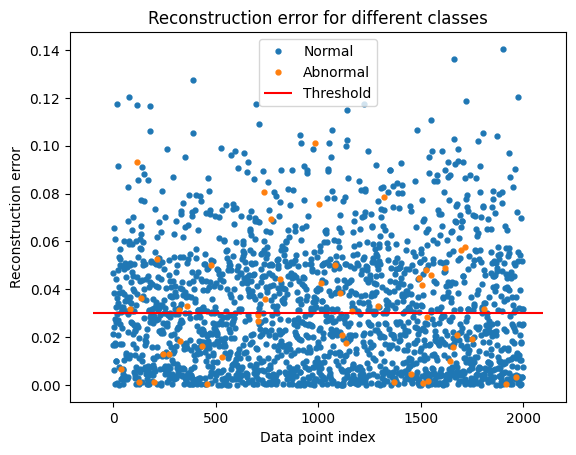

In [45]:
result = recon_err_plot(x_val, pred, y_val, .03)

* precision_recall_f1_curve

/tmp/ipykernel_14031/3279574342.py:6: RuntimeWarning: divide by zero encountered in divide
  f1 = 2 / (1/precision + 1/recall)


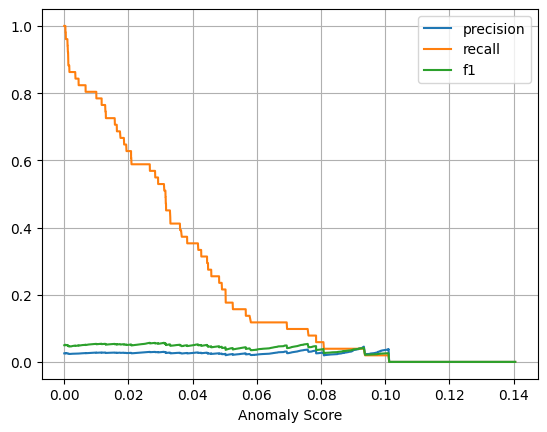

In [46]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

In [47]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.031057080544746006

* f1을 최대화 하는 threshold 값으로 평가

In [49]:
classification_report2(result['True_class'], result['Reconstruction_error'], thres_f1_max)

< confusion matrix >

[[1079  870]
 [  25   26]]


< classification_report >

              precision    recall  f1-score   support

           0       0.98      0.55      0.71      1949
           1       0.03      0.51      0.05        51

    accuracy                           0.55      2000
   macro avg       0.50      0.53      0.38      2000
weighted avg       0.95      0.55      0.69      2000

